In [1]:
import numpy as np
import scipy.stats as st
import scipy.constants as constants
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Markov Chain Monte Carlo Sampling

In my opinion, the ultimate goal of modern statistical computing is efficient Monte Carlo sampling. More precisely, given a distrubution $p(x)$ where $x \in X$, we want to sample from $p$. For example, in Bayesian inference, we want to sample from $p(\theta | x) \propto p(x | \theta) p (\theta)$ because it contains the information we learn about $\theta$ from $x$, and we can use samples to produce histograms. If $X$ is low dimensional and has a small number of connected components, then it is easy to dream up niave algorithms which sample from $p$. If $X$ is high dimensional or has a large number of connected components, niave algorithms do not work well. This is explained beautifully in chapter 29 of David MacKay's Book, [Information Theory, Inference and Learning Algorithms](http://www.inference.phy.cam.ac.uk/itprnn/book.html).

One way to sample from $p$ is to produce a Markov Chain on $X$ whose stationary distrubution is $p$. Algorithms based of this idea are called Markov chain Monte Carlo algorithms. In this notebook, we shall focus on the Metropolis algorithm, which is the simplest MCMC algorithm. To run the algorithm, we also need a distrubution $q(x'|x)$ on $X$ parameterized by $X$ from which we can sample. For example, if $X$ is Euclidean space, we can take $q$ to be a multivariate normal distrubution with mean $x$. Here is pseudo-code for the transition step:

```
input x, p, q
sample x' <- q(x',x)
a = p(x') * q(x,x') / p(x) * q(x',x)
if a >= 1 then return x'
          else sample u <- Uniform(0,1)
               if u <= a then return x'
                         else return x
```


*Notice that we only need $p$ upto multiplication by a constant.* Suppose that $q(x'|x) = q(x|x')$ (this is the case when $q$ is a multivariate normal distrubution). Then $a = p(x') / p(x)$. The intuition is that if $p(x') \geq p(x)$, then the Markov chain will transition to $x'$. Therefore the stationary distrubution should be concentrated in the parts of $X$ where $p(x)$ is high. We can make this more precise as follows: Suppose that $X$ is discrete. Then this pseudo-code defines a Markov chain on $X$ with transition probability:

$$
k(x'|x) =
\begin{cases}
q(x'|x) & x' \not= x \quad a(x',x) \geq 1 \\
q(x'|x) a(x',x) & x' \not= x \quad a(x',x) < 1 \\
q(x'|x) + \sum_{z:a(z,x) < 1} q(z|x)(1 - a(z,x)) & x' = x
\end{cases}
$$

$${\rm where} \; \; a(x',x) = \frac{p(x') q(x | x')}{p(x) q(x'|x)}$$

This Markov chain satisfies $k(x' | x) p(x) = k(x | x') p(x')$ which implies that

$$\sum_x k(x' | x) p(x) = p(x').$$

Therefore $p$ is the stationary distrubution of $k$. It is possible to construct a similar proof when $X$ is a manifold. Now let us implement the Metropolis algorithm and look at some simple examples.

In [2]:
def transition(current_state,logp,logq,genq):
    
    new_state = genq(current_state)
    # we use log probabilities to avoid underflow
    loga = logp(new_state) + logq(current_state,new_state) - logp(current_state) - logq(new_state,current_state)

    if loga >= 0:
        return new_state

    u = st.uniform.rvs()

    if np.log(u) <= loga:
        return new_state
    else:
        return current_state



def sample(initial_state,logp,logq,genq,num_samples):
    current_state = initial_state
    samples = [initial_state]
    for i in range(num_samples):
        current_state = transition(current_state,logp,logq,genq)
        samples.append(current_state)
    return np.array(samples)

In [3]:
#sampling from a normal distrubution with the metropolis algorithm
logp = st.norm().logpdf
def logq(x_prime,x): return st.norm.logpdf(x_prime,loc=x)
def genq(x): return st.norm.rvs(loc=x)

In [4]:
sample_mcmc = sample(0,logp,logq,genq,10000)
sample_real = np.random.normal(0,1,10000)

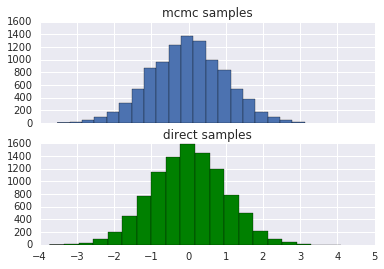

In [5]:
p, ax1 = plt.subplots(2,sharex=True,sharey=True)
ax1[0].hist(sample_mcmc,bins=20)
ax1[0].set_title("mcmc samples")
ax1[1].hist(sample_real,bins=20,color='g')
ax1[1].set_title("direct samples")
plt.show()

In [6]:
#sampling from a quadmodal distrubution with the metropolis algorithm
def logp(x):
    return np.log(np.power(np.sin(x), 2)) if 0 < x < (4 * constants.pi) else np.log(0)
def logq(x_prime,x): return st.norm.logpdf(x_prime,loc=x)
def genq(x): return st.norm.rvs(loc=x)

In [7]:
sample_mcmc = sample(0,logp,logq,genq,50000)

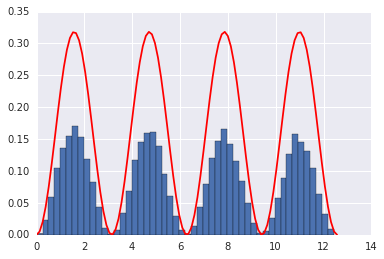

In [8]:
plt.hist(sample_mcmc,bins=50,normed=True)
xs = np.linspace(0, 4*constants.pi, num=100)
plt.plot(xs, np.power(np.sin(xs), 2) / constants.pi, color="r")
plt.show()

In [9]:
#sampling from a multivariate normal distrubution with the metropolis algorithm
logp = lambda x: st.multivariate_normal(mean=[0,0], cov=[[1,0.5],[0.5,2]]).logpdf(x)
def logq(x_prime,x): return st.multivariate_normal.logpdf(x_prime,mean=x,cov=[[1,0],[0,1]])
def genq(x): return st.multivariate_normal.rvs(mean=x,cov=[[1,0],[0,1]])

In [10]:
sample_mcmc = sample(np.array([0,0]),logp,logq,genq,5000)
x = sample_mcmc[:,0]
y = sample_mcmc[:,1]

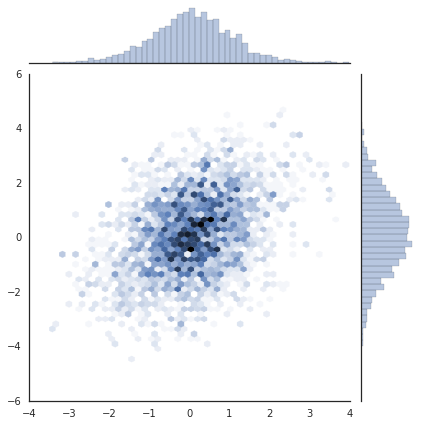

In [11]:
with sns.axes_style("white"):
    sns.jointplot(x=x, y=y, kind="hex",stat_func=None);